In [1]:
import inspect
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection

import pymc3 as pm
from pymc3 import sampling_jax

import theano.tensor as tt
import arviz as az

# %matplotlib

In [2]:
track = pd.read_csv('../examples/data/modes.csv')
track.head()

,frac_age,delta_nu_fit,nu_max,nu_0_1,nu_0_2,nu_0_3,nu_0_4,nu_0_5,nu_0_6,nu_0_7,...,nu_0_32,nu_0_33,nu_0_34,nu_0_35,nu_0_36,nu_0_37,nu_0_38,nu_0_39,nu_0_40,surface_he4
0,0.000016,11.884045,150.680452,0.0,34.481794,49.329712,63.195077,75.913367,87.630758,99.483102,...,392.064627,403.710370,415.297909,426.924218,438.655667,450.550178,462.546781,474.658899,486.825847,0.239966
1,0.000017,12.140476,154.893200,0.0,35.203007,50.376320,64.548471,77.583389,89.569246,101.679667,...,400.620086,412.538305,424.386957,436.252351,448.212638,460.326691,472.558635,484.919720,497.325734,0.239967
2,0.000017,12.343045,158.238356,0.0,35.772049,51.202159,65.616199,78.900744,91.100159,103.413323,...,407.368711,419.505074,431.563921,443.619056,455.762984,468.048949,480.469626,493.018551,505.616340,0.239968
3,0.000018,12.503403,160.898485,0.0,36.222266,51.855582,66.460893,79.942765,92.312228,104.785371,...,412.708426,425.019262,437.245702,449.452226,461.742276,474.164224,486.734715,499.427290,512.179364,0.239969
4,0.000018,12.633487,163.061612,0.0,36.587368,52.385499,67.145867,80.787635,93.295718,105.898357,...,417.037759,429.491253,441.854064,454.184875,466.594022,479.127384,491.819429,504.626946,517.505773,0.239969


In [3]:
# profile = track.loc[track['frac_age'] < 0.5].iloc[-1]
profile = track.loc[600]

In [4]:
nu_index = [f'nu_0_{i}' for i in range(10, 30)]

def get_nu(profile):
    nu = profile[nu_index].to_numpy().astype(float)
    nu = nu[nu > 0.0]  # Values equal to zero correspond to no calculation
    return nu

nu = get_nu(profile)

In [5]:
nu

array([1462.27571298, 1591.71073593, 1719.49277863, 1847.04715688,
       1975.37585221, 2103.70865688, 2230.4634227 , 2356.93239647,
       2483.78162935, 2611.8985408 , 2740.53392867, 2869.15043926,
       2997.963176  , 3126.77337843, 3256.15970241, 3385.89809743,
       3515.94349483, 3646.10714887, 3776.26474691, 3906.62692869])

In [6]:
# Scaling relation nu_max
numax = profile['nu_max']
print('numax ~', round(numax, 2), 'muHz')

# Delta_nu fit to radial modes about nu_max
dnu = profile['delta_nu_fit']
print('dnu ~', round(dnu, 2), 'muHz')

numax ~ 2853.19 muHz
dnu ~ 128.7 muHz


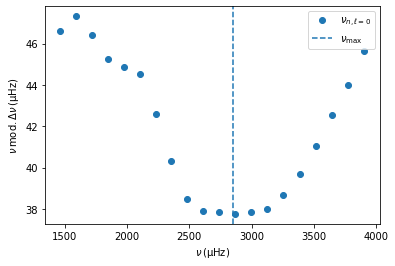

In [7]:
numod = nu % dnu

fig, ax = plt.subplots()

ax.plot(nu, numod, 'o', label=r'$\nu_{n,\ell = 0}$')
ax.axvline(numax, linestyle='--', label=r'$\nu_\mathrm{max}$')
ax.set_ylabel(r'$\nu\,\mathrm{mod.}\Delta\nu\,(\mathrm{\mu Hz})$')
ax.set_xlabel(r'$\nu\,(\mathrm{\mu Hz})$')

ax.legend()

In [8]:
def asy_background(n, epsilon, alpha, delta_nu, nu_max):
    n_max = nu_max / delta_nu - epsilon
    return delta_nu * (n + epsilon + 0.5 * alpha * (n - n_max)**2)

def he_amplitude(nu, b0, b1, lib=tt):
    return b0 * nu * lib.exp(- b1 * nu**2)

def he_glitch(nu, b0, b1, tau_he, phi_he, lib=tt):
    return he_amplitude(nu, b0, b1, lib=lib) * lib.sin(4 * np.pi * tau_he * nu + phi_he)

In [9]:
1/numax

0.00035048457232552424

In [10]:
n = np.arange(10, 30)

epsilon = 1.3
alpha = 0.001
b0 = 10/numax
b1 = 2/numax**2
tau_he = 0.0006
phi_he = np.pi-0.01

delta_nu = dnu
nu_max = numax - 100

glitch = he_glitch(nu, b0, b1, tau_he, phi_he, lib=np)
asy = asy_background(n, epsilon, alpha, delta_nu, nu_max)
model = asy + glitch

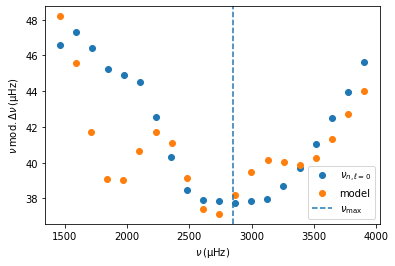

In [11]:
numod = nu % dnu
modelmod = model % dnu

fig, ax = plt.subplots()

ax.plot(nu, numod, 'o', label=r'$\nu_{n,\ell = 0}$')
ax.plot(model, modelmod, 'o', label=r'model')

ax.axvline(numax, linestyle='--', label=r'$\nu_\mathrm{max}$')
ax.set_ylabel(r'$\nu\,\mathrm{mod.}\Delta\nu\,(\mathrm{\mu Hz})$')
ax.set_xlabel(r'$\nu\,(\mathrm{\mu Hz})$')

ax.legend()

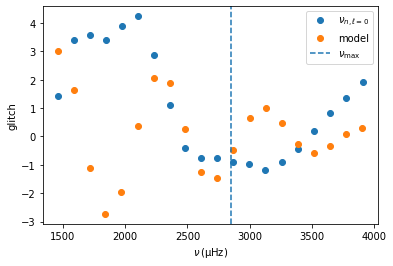

In [12]:
fig, ax = plt.subplots()

ax.plot(nu, nu - asy , 'o', label=r'$\nu_{n,\ell = 0}$')
ax.plot(model, glitch, 'o', label=r'model')

ax.axvline(numax, linestyle='--', label=r'$\nu_\mathrm{max}$')
ax.set_ylabel(r'glitch')
ax.set_xlabel(r'$\nu\,(\mathrm{\mu Hz})$')

ax.legend()

In [14]:
with pm.Model() as model_asy:
    
    epsilon = pm.Normal('epsilon', 1.3, 0.2)
    alpha = pm.Lognormal('alpha', tt.log(0.001), 1.0)
    delta_nu = pm.Normal('delta_nu', dnu, 1.0)
    nu_max = pm.Normal('nu_max', numax, numax*0.05)

    nu_err = pm.HalfNormal('nu_err', 0.1)

    nu_model = pm.Deterministic('nu_model', asy_background(n, epsilon, alpha, delta_nu, nu_max))
    
    nu_obs = pm.Normal('nu_obs', nu_model, nu_err, observed=nu)

In [15]:
from pymc3 import sampling_jax

/Users/ajl573/.virtualenvs/base/lib/python3.8/site-packages/pymc3/sampling_jax.py:24: UserWarning: This module is experimental.
  warnings.warn("This module is experimental.")


In [16]:
with model_asy:
    trace_asy = sampling_jax.sample_numpyro_nuts(tune=2000, chains=10, target_accept=0.95)

Compiling...


/Users/ajl573/.virtualenvs/base/lib/python3.8/site-packages/jax/interpreters/xla.py:682: UserWarning: The jitted function _sample includes a pmap. Using jit-of-pmap can lead to inefficient data movement, as the outer jit does not preserve sharded data representations and instead collects input and output arrays onto a single device. Consider removing the outer jit unless you know what you're doing. See https://github.com/google/jax/issues/2926.
  warn(f"The jitted function {fun.__name__} includes a pmap. Using "


Compilation + sampling time =  0 days 00:00:12.365502
Transformation time =  0 days 00:00:00.972452


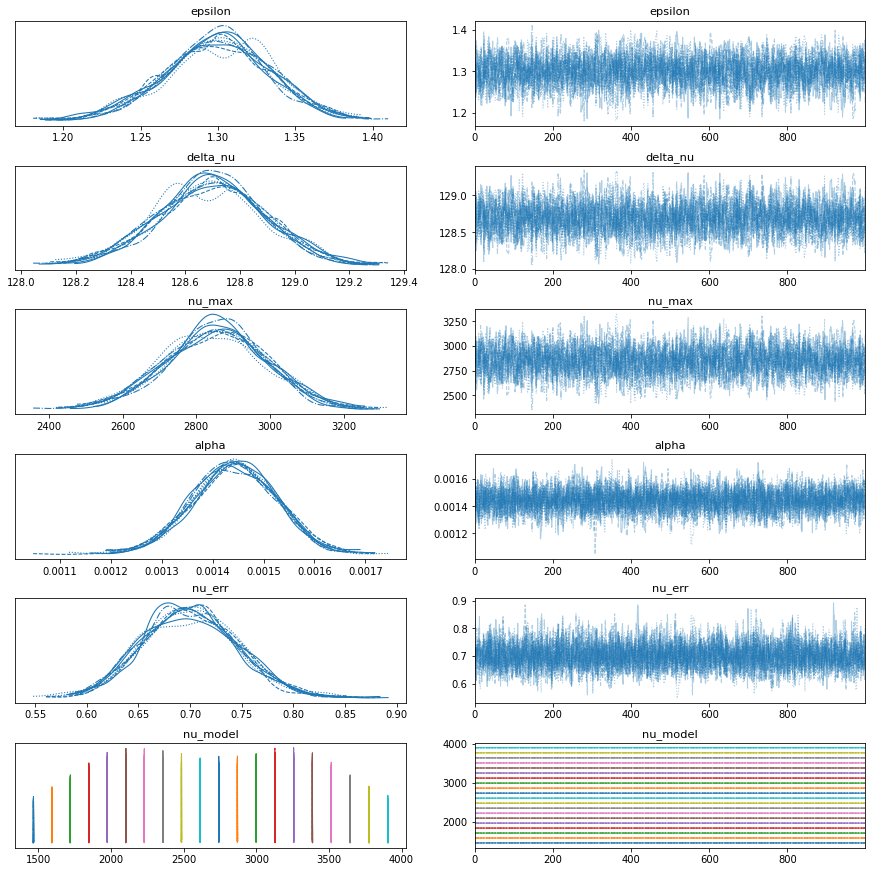

In [17]:
with model_asy:
    ax = az.plot_trace(trace_asy, compact=True)

In [18]:
with model_asy:
    df = az.summary(trace_asy)
df.head()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
epsilon,1.300,0.034,1.232,1.362,0.001,0.000,2707.0,3639.0,1.0
delta_nu,128.695,0.199,128.321,129.070,0.004,0.003,2706.0,3675.0,1.0
nu_max,2853.089,136.573,2599.951,3112.821,2.603,1.845,2750.0,3900.0,1.0
alpha,0.001,0.000,0.001,0.002,0.000,0.000,4819.0,4256.0,1.0
nu_err,0.701,0.046,0.619,0.787,0.001,0.000,5236.0,5072.0,1.0


In [22]:
with pm.Model() as model_glitch:
    
    epsilon = pm.Normal('epsilon', 1.3, 0.2)
    alpha = pm.Lognormal('alpha', tt.log(1e-3), 1.0)
    delta_nu = pm.Normal('delta_nu', dnu, 1.0)
    nu_max = pm.Normal('nu_max', numax, numax*0.05)
    
    b0 = pm.Lognormal('b0', tt.log(1/numax), 1.0)
    b1 = pm.Lognormal('b1', tt.log(1/numax**2), 1.0)
    tau = pm.Lognormal('tau', tt.log(0.001), 0.5)
    phi = pm.VonMises('phi', 0.0, 1.0)

    nu_err = pm.HalfNormal('nu_err', 0.1)
    
    nu_asy = pm.Deterministic('nu_asy', asy_background(n, epsilon, alpha, delta_nu, nu_max))
    nu_glitch = pm.Deterministic('nu_glitch', he_glitch(nu_asy, b0, b1, tau, phi))
    
    nu_model = pm.Deterministic('nu_model', nu_asy + nu_glitch)
    
    nu_obs = pm.Normal('nu_obs', nu_model, nu_err, observed=nu)

In [23]:
with model_glitch:
    trace_glitch = sampling_jax.sample_numpyro_nuts(tune=2000, chains=10, target_accept=0.95)

Compiling...


/Users/ajl573/.virtualenvs/base/lib/python3.8/site-packages/jax/interpreters/xla.py:682: UserWarning: The jitted function _sample includes a pmap. Using jit-of-pmap can lead to inefficient data movement, as the outer jit does not preserve sharded data representations and instead collects input and output arrays onto a single device. Consider removing the outer jit unless you know what you're doing. See https://github.com/google/jax/issues/2926.
  warn(f"The jitted function {fun.__name__} includes a pmap. Using "


Compilation + sampling time =  0 days 00:00:18.827147
Transformation time =  0 days 00:00:30.827612


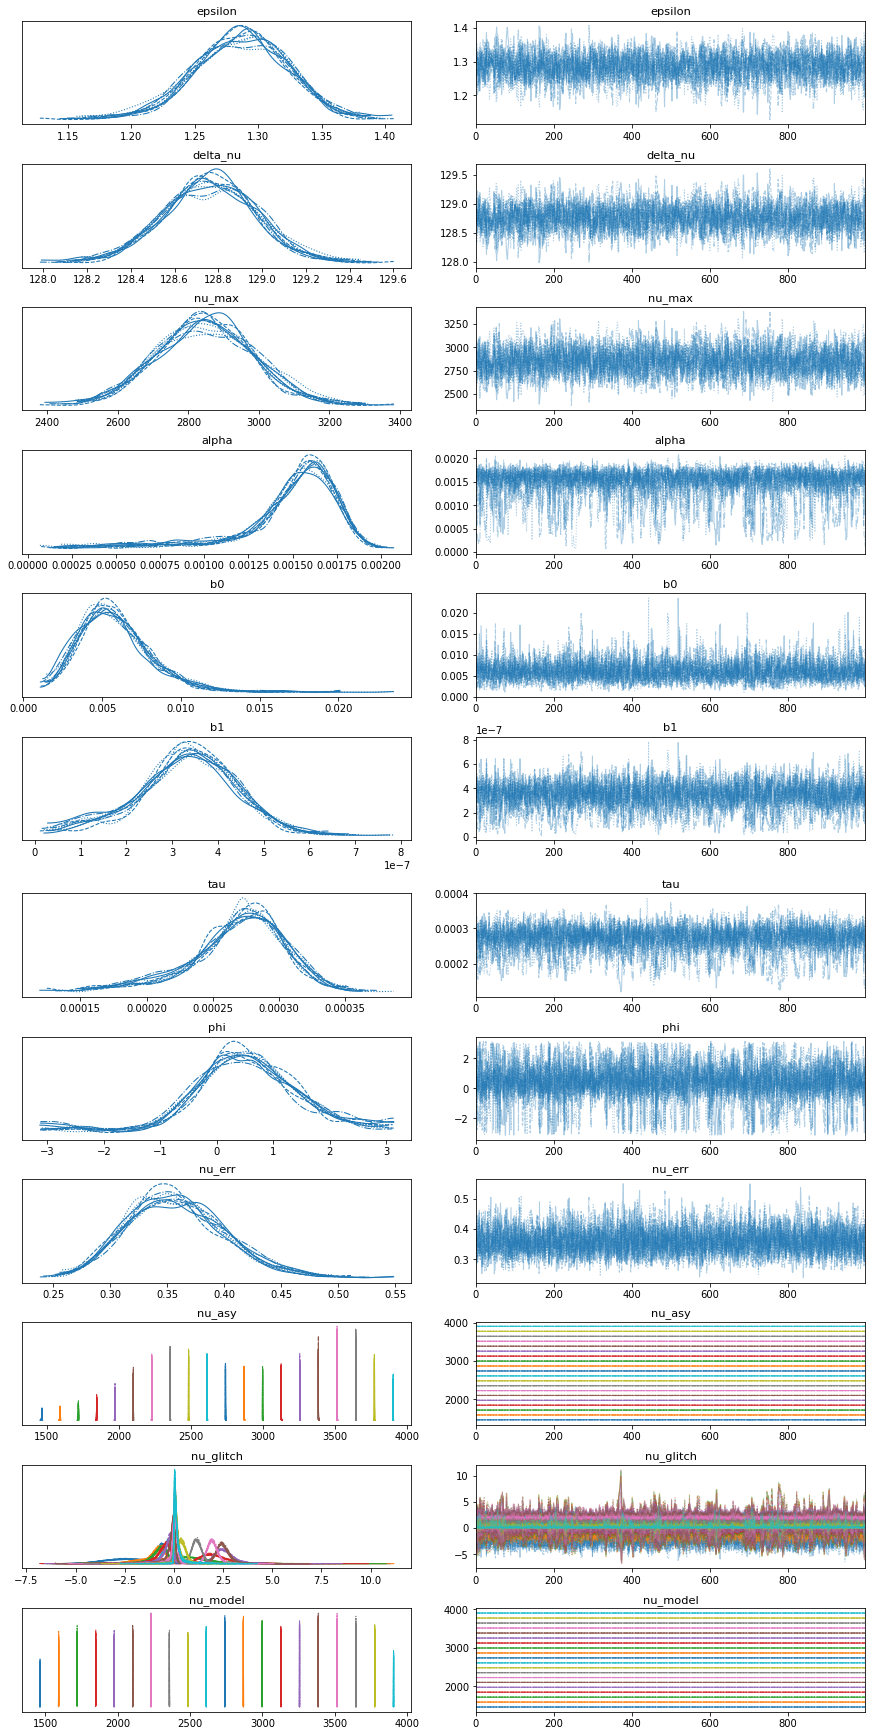

In [24]:
with model_glitch:
    ax = az.plot_trace(trace_glitch, compact=True)

In [29]:
posterior = trace_glitch.posterior.to_dataframe()
posterior.head()

KeyboardInterrupt: 